***
<h2 style="font-size: 25px; font-family: 'Algerian'; color: green; text-align: center;">Predicción de Consumo Energético con LSTM (TensorFlow)</h2>

***

<p style="font-size: 15px; font-family: 'Arial'; color: black; text-align: justify; text-indent: 20px">
Dado que el <i>consumo energético</i> tiene una dependencia a lo largo del tiempo, emplear modelos que puedan capturar la dinámica temporal es fundamental. Por ello, las <i>redes neuronales recurrentes (RNN)</i>, como <i>LSTM</i>, resultan especialmente útiles, ya que mantienen un estado interno que les permite recordar información de pasos anteriores, lo cual es ideal para modelar patrones secuenciales y temporales.   
</p>

<p style="font-size: 15px; font-family: 'Arial'; color: black; text-align: justify; text-indent: 20px">
 En este proyecto, se utiliza el optimizador <i>Adam</i> pues combina las ventajas de otros métodos, como el <i>descenso del gradiente con momentum</i> y la <i>adaptación del paso de aprendizaje</i>, lo que permite una convergencia más rápida y estable, incluso en datos ruidosos o escasos. Por lo tanto, el uso de <i>LSTM</i> como arquitectura de red y <i>Adam</i> como optimizador proporciona una solución eficaz y eficiente para predecir valores futuros de consumo energético a partir de secuencias pasadas, aprovechando tanto la memoria de largo plazo como la capacidad de ajuste automático durante el entrenamiento.
</p>

Epoch 1/10


/home/carlos/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0186 - val_loss: 0.0018
Epoch 2/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0048 - val_loss: 0.0013
Epoch 3/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0043 - val_loss: 0.0012
Epoch 4/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0040 - val_loss: 0.0012
Epoch 5/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0040 - val_loss: 0.0011
Epoch 6/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0036 - val_loss: 0.0010
Epoch 7/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0039 - val_loss: 9.9804e-04
Epoch 8/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0035 - val_loss: 9.1498e-04
Epoch 9/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0034 - val_loss: 8.8004e-04
Epoch 10/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0036 - val_loss: 9.0851e-04
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0056
Test Loss: 0.0084
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


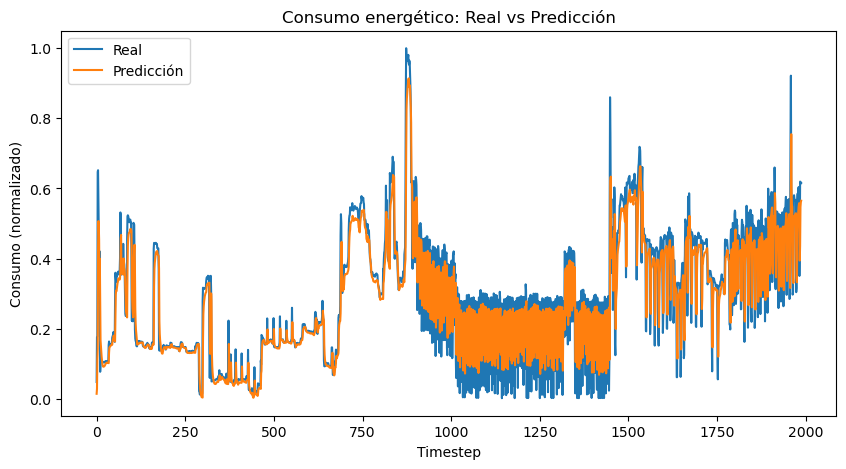

Raíz del promedio de los cuadrados de los errores (RMSE): 0.0914
Promedio de las diferencias absolutas (MAE): 0.0620
El nivel de ajuste de las predicciones al resultado real es (R² Score): 0.7368


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Se cargará el dataset. Del original se tomaron solo los primeros 10000 datos de los 2075260 que había, manteniendo el formato.
df = pd.read_csv("sample_of_household_power_consumption.csv", skipinitialspace = True, header = 1, low_memory = False, na_values=['nan','?'])


# Se creará una columna llamada "datetime" para facilitar el trabajo con las series temporales.
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format = '%d/%m/%Y %H:%M:%S', errors = 'coerce')


# Se eliminarán filas con datetime nulo o valores faltantes.
df = df.dropna(subset = ['datetime', 'Global_active_power'])
df['Global_active_power'] = df['Global_active_power'].astype(float)
df = df.sort_values('datetime').reset_index(drop = True)


# Aquí se normalizará la columna objetivo "Global active power".
scaler = MinMaxScaler()
df['Global_active_power'] = scaler.fit_transform(df[['Global_active_power']])


# Comenzando con la creación de secuencias para LSTM.
def create_sequences(data, size):
    X, y = [], []
    for i in range(len(data) - size):
        X.append(data[i:i+size])
        y.append(data[i+size])
    return np.array(X), np.array(y)

size = 60
X, y = create_sequences(df['Global_active_power'].values, size)
X = np.expand_dims(X, axis=2)


# Para el entrenamiento y prueba se dividirán los datos de la siguiente manera:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = False)


# Se definirá el modelo LSTM.
model = Sequential([
    LSTM(64, return_sequences = False, input_shape = (size, 1)),
    Dropout(0.2), 
    Dense(32, activation='relu'),
    Dense(1)
])


# Dicho modelo, se compilará con optimizador Adam.
optimizer = Adam(learning_rate = 0.001)
model.compile(optimizer = optimizer, loss = 'mse')


# Se comenzará con el entrenamiento del modelo.
history = model.fit(X_train, y_train, epochs = 10, batch_size = 64, validation_split = 0.1)


# Se evaluará el modelo.
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")


# Por último, se visualizarán los resultados en una gráfica y se mostrará cuán aproximado fue el modelo a los valores reales.
predictions = model.predict(X_test)
plt.figure(figsize = (10,5))
plt.plot(y_test, label = 'Real')
plt.plot(predictions, label = 'Predicción')
plt.legend()
plt.title("Consumo energético: Real vs Predicción", color = "red")
plt.xlabel("Timestep")
plt.ylabel("Consumo (normalizado)")
plt.show()

rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f"Raíz del promedio de los cuadrados de los errores (RMSE): {rmse:.4f}")
print(f"Promedio de las diferencias absolutas (MAE): {mae:.4f}")
print(f"El nivel de ajuste de las predicciones al resultado real es (R² Score): {r2:.4f}")
